In [2]:
import os
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from src.yolo import thetis_model
from src.utils import get_video_properties

In [3]:
class ThetisDataset:
    def __init__(self, csv_file=None, root_dir=None, transform=None, train=True, use_features=True, class_names=True,
                 features_len=100):
        self.model = thetis_model
        self.videos_name = csv_file
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.use_features = use_features
        self.seq_length = 18 # 최근의 18개의 동작 데이터를 보고 다음 동작을 예측, FPS로 설정
        self.columns = [
            'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 
            'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 
            'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
        ]
        self.class_names = {'backhand2hands': '2BH', 'backhand': 'BHD', 'backhand_slice': 'BSL', 'backhand_volley': 'BVY', 
                            'forehand_flat': 'FFT', 'forehand_openstands': 'FOS', 'forehand_slice': 'FSL', 'forehand_volley': 'FVY', 
                            'flat_service': 'SFT', 'kick_service': 'SKK', 'slice_service': 'SSL', 'smash': 'SMS'}
        self.classes = {'backhand2hands': 0, 'backhand': 1, 'backhand_slice': 2, 'backhand_volley': 3, 
                        'forehand_flat': 4, 'forehand_openstands': 5, 'forehand_slice': 6, 'forehand_volley': 7,  
                        'flat_service': 8, 'kick_service': 9, 'slice_service': 10, 'smash': 11}
        self.keypoints_list = []
        self.features_len = features_len


    def collect_datasets(self, motion):
        """
        Collect data for a specific motion from a CSV file containing video paths
        and Calculate keypoints for each frame in the videos and saves them in a CSV file.
        """
        csv_file_path = 'csv/extract_video_paths.csv'
        df = pd.read_csv(csv_file_path)

        output_path = f"keypoints/{motion}.csv" # Keypoints를 저장할 CSV 파일

        motion_video_paths = df[df['motion'] == motion] # 특정 Motion에 대한 Video paths 추출
        class_idx = np.array([self.classes[motion]], dtype=np.float32) # Motion의 Label Number

        for idx, row in motion_video_paths.iterrows():
            video_path = row['video_path']

            self.save_keypoints(video_path, class_idx) # 52 x 1 배열

        self.save_keypoints_to_csv(output_path) # 하나의 motion에 대한 keypoint 리스트를 csv 파일에 저장

        self.keypoints_list = [] # 한 Motion에 대한 좌표를 모두 저장했으면 다음 Motion을 위해 초기화


    def save_keypoints(self, video_path, class_idx):
        """
        Process a video to calculate keypoints and appends them to a list
        """
        video = cv2.VideoCapture(video_path)

        if not video.isOpened():
            print(f"Error: Could not open video '{video_path}'")
            return
        
        fps, _, _, _ = get_video_properties(video)
        self.seq_length = int(fps)
        
        while True:
            ret, frame = video.read()

            if not ret:
                break

            keypoints_xyv = self.calculate_keypoints(frame) # YOLO 모델 적용해서 keypoints 좌표 계산

            data = np.append(keypoints_xyv, class_idx)
            self.keypoints_list.append(data)
    

    def calculate_keypoints(self, image):
        """
        Calculate keypoints for a frame using a YOLO pose model
        """
        results = self.model.predict(image)

        for result in results:
            kpts = result.keypoints.data[0].cpu().numpy() # 17 x 3 배열
            keypoints_xyv = kpts.flatten() # [x1, y1, v1, x2, y2, v2, ...] -> 51 x 1 배열

        return keypoints_xyv
    
    
    def save_keypoints_to_csv(self, output_path):
        """
        Save the collected keypoints to a CSV file
        """
        columns = [f'{motion}_{coord}' for motion in self.columns for coord in ['x', 'y', 'v']] + ['class']
        df = pd.DataFrame(self.keypoints_list, columns=columns)
        df.to_csv(output_path, index=False)

    
    def create_sequence_dataset(self):

        x_train, y_train, x_valid, y_valid, x_test, y_test = split_train_valid_test_datasets()
        
        x_train_sequence, y_train_sequence = self.convert_sequence_dataset(x_train, y_train)
        x_valid_sequence, y_valid_sequence = self.convert_sequence_dataset(x_valid, y_valid)
        x_test_sequence, y_test_sequence = self.convert_sequence_dataset(x_test, y_test)

        return x_train_sequence, y_train_sequence, x_valid_sequence, y_valid_sequence, x_test_sequence, y_test_sequence
    
    
    def convert_sequence_dataset(self, x_data, y_data):
        x_dataset = []
        y_dataset = []

        for i in range(len(x_data) - self.seq_length):
            _x = x_data[i:i + self.seq_length]
            x_dataset.append(_x)
            _y = y_data[i] 
            y_dataset.append(_y)

        return np.array(x_dataset), np.array(y_dataset)

In [4]:
def save_video_paths_to_csv():
    """
    Save the path of videos as CSV file
    """
    base_path = "THETIS\VIDEO_RGB"

    data = []
    for motion in os.listdir(base_path):
        motion_path = os.path.join(base_path, motion)
        
        if os.path.isdir(motion_path):
            for video_name in os.listdir(motion_path):
                video_path = os.path.join(motion_path, video_name)
                data.append([motion, video_name, video_path])
                    
    df = pd.DataFrame(data, columns=["motion", "video_name", "video_path"])
    df.to_csv("csv/total_video_paths.csv", index=False)

In [5]:
def separate_video_paths():
    """
    Separate video paths
    """
    video_paths = 'csv/total_video_paths.csv'
    df = pd.read_csv(video_paths)

    extract_video_paths_list = []
    remaining_video_paths_list = []
    motions = ['backhand2hands', 'backhand', 'backhand_slice', 'backhand_volley', 
               'forehand_flat', 'forehand_openstands', 'forehand_slice', 'forehand_volley', 
               'flat_service', 'kick_service', 'slice_service', 'smash']
    
    for motion in motions:
        motion_video_data = df[df['motion'] == motion]

        for idx, row in motion_video_data.iterrows():
            video_name = row['video_name']
            video_path = row['video_path']

            video = cv2.VideoCapture(video_path)
            if not video.isOpened():
                print(f"Error: Could not open video '{video_path}'")
                break

            pose_count = 0
            while pose_count == 0:
                ret, frame = video.read()
                if not ret:
                    break

                results = thetis_model.predict(frame)
                for result in results:
                    kpts = result.keypoints.xy
                    if len(kpts) >= 2:
                        pose_count += 1
            
            if pose_count == 0:
                extract_video_paths_list.append([motion, video_name, video_path])
            else:
                remaining_video_paths_list.append([motion, video_name, video_path])

    train_path_df = pd.DataFrame(extract_video_paths_list, columns=["motion", "video_name", "video_path"])
    train_path_df.to_csv('csv/extract_video_paths.csv', index=False)

    valid_path_df = pd.DataFrame(remaining_video_paths_list, columns=["motion", "video_name", "video_path"])
    valid_path_df.to_csv('csv/remaining_video_paths.csv', index=False)

In [6]:
def split_datasets(df):
    length = len(df)
    a = int(length * 0.8)
    b = int((length - a) / 2 + 1)

    train = df[:a]
    valid = df[a:a+b]
    test = df[a+b:]

    return train, valid, test

In [7]:
def split_train_valid_test_datasets():
    """
    Split THETIS Dataset into train, validation and test sets
    """
    base_path = 'keypoints/'

    train_dfs = []
    valid_dfs = []
    test_dfs = []
    
    # 하나의 동작에 대한 csv 파일에서 train/valid/test로 나눔
    for csv_file in os.listdir(base_path):
        df = pd.read_csv(base_path + csv_file)

        train, valid, test = split_datasets(df)

        train_dfs.append(train)
        valid_dfs.append(valid)
        test_dfs.append(test)

    train_df = pd.concat(train_dfs, ignore_index=True)
    valid_df = pd.concat(valid_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)

    x_train = train_df.drop('class', axis=1).values
    y_train = to_categorical(train_df['class'].reset_index(drop=True).values, num_classes=12)

    x_valid = valid_df.drop('class', axis=1).values
    y_valid = to_categorical(valid_df['class'].reset_index(drop=True).values, num_classes=12)

    x_test = test_df.drop('class', axis=1).values
    y_test = to_categorical(test_df['class'].reset_index(drop=True).values, num_classes=12)

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [8]:
def combine_motion_data():
    """
    Combine data from CSV files separated by motion classes
    """
    base_path = 'keypoints/'
    
    dfs = []
    for csv_file in os.listdir(base_path):
        df = pd.read_csv(base_path + csv_file)
        dfs.append(df)

    total_df = pd.concat(dfs, ignore_index=True)
    return total_df

In [10]:
df = combine_motion_data()
print(df)

          nose_x      nose_y    nose_v  left_eye_x  left_eye_y  left_eye_v  \
0      284.28320  109.346530  0.998962   290.87445  103.577760    0.993697   
1      284.47560  109.250030  0.998994   291.04633  103.436600    0.993807   
2      284.27880  109.260100  0.999057   291.03040  103.554596    0.994616   
3      284.34564  109.117160  0.999002   290.93436  103.351030    0.994306   
4      284.52396  108.998920  0.998959   291.02112  103.220460    0.993711   
...          ...         ...       ...         ...         ...         ...   
50832  286.28436   60.956160  0.983326   292.07196   51.036156    0.891326   
50833  290.13553   59.955795  0.983969   296.12863   50.046066    0.897100   
50834  294.64990   59.133118  0.983409   300.78125   49.741730    0.886267   
50835  299.85200   58.966920  0.983556   306.12610   50.236176    0.887627   
50836  312.76468   60.876343  0.987016   319.50280   52.865143    0.897415   

       right_eye_x  right_eye_y  right_eye_v  left_ear_x  ...  

In [11]:
thetis = ThetisDataset()

x_train, y_train, x_valid, y_valid, x_test, y_test = thetis.create_sequence_dataset()

print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

print(x_test.shape)
print(y_test.shape)

(40648, 18, 51)
(40648, 12)
(5077, 18, 51)
(5077, 12)
(5058, 18, 51)
(5058, 12)


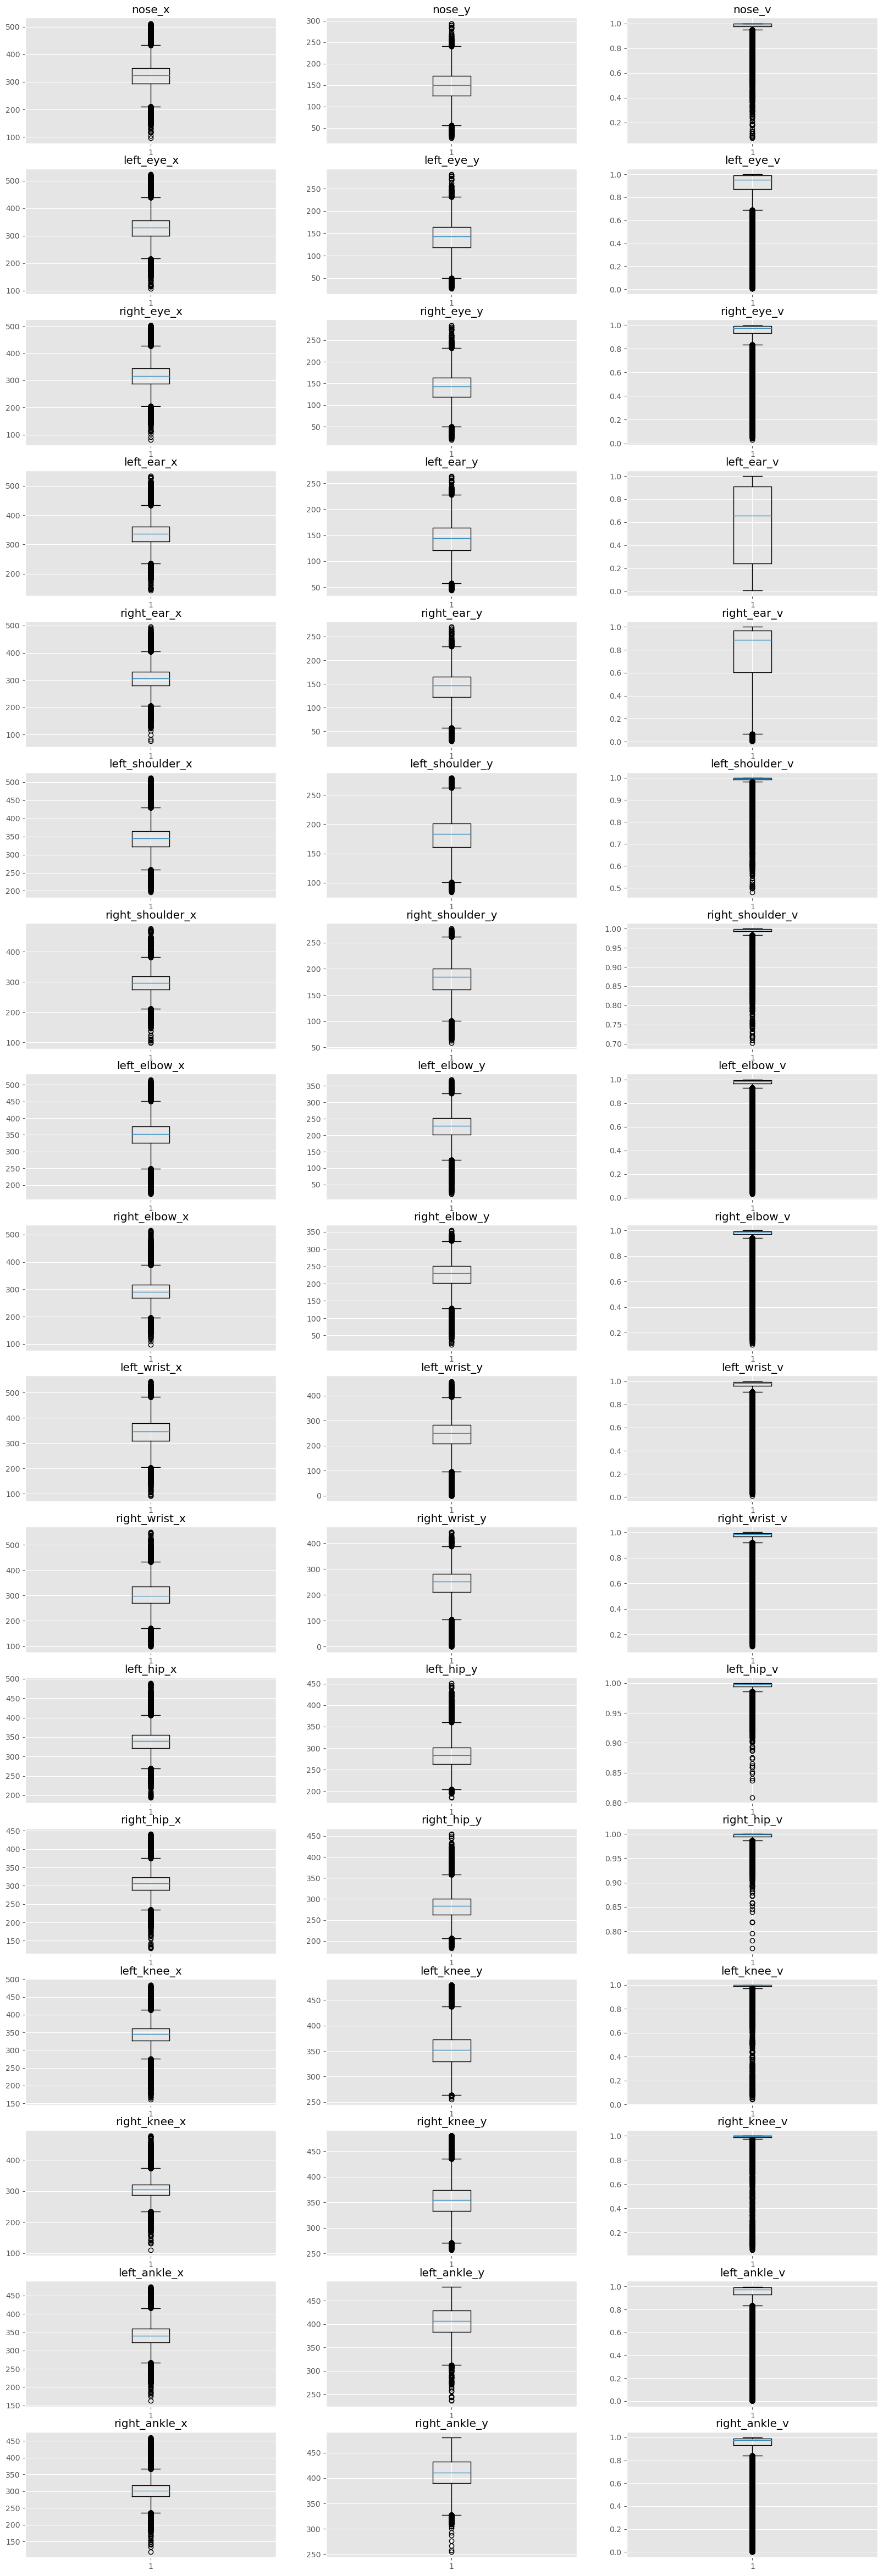

In [12]:
# Boxplot을 사용하여 데이터의 분포 확인
feature = df.columns[:-1]
plt.figure(figsize=(20,60))

for i in range(len(feature)):
    plt.subplot(17,3,i+1)
    plt.title(feature[i])
    plt.boxplot(df[feature[i]])
plt.show()

In [14]:
gr_mu = df.groupby('class').mean().iloc[:, :]
gr_mu

,nose_x,nose_y,nose_v,left_eye_x,left_eye_y,left_eye_v,right_eye_x,right_eye_y,right_eye_v,left_ear_x,...,left_knee_v,right_knee_x,right_knee_y,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_v
class,,,,,,,,,,,,,,,,,,,,,
0.0,302.414941,145.246061,0.978273,308.345439,137.052968,0.930447,296.406796,137.454076,0.875955,320.100439,...,0.988487,294.025393,348.619738,0.984753,340.613910,416.314814,0.921913,300.088975,401.565835,0.915718
1.0,317.885454,144.161981,0.978281,323.317342,136.300505,0.914031,312.047262,136.620347,0.880088,333.052407,...,0.994253,301.774587,338.484887,0.992571,351.072082,403.135628,0.963231,304.169901,394.478981,0.959780
2.0,305.864239,148.444449,0.978049,311.965217,139.990120,0.942488,299.646534,140.413686,0.882212,324.118633,...,0.978883,299.879412,353.145231,0.972839,337.218717,418.131005,0.879544,308.185631,406.500528,0.870199
3.0,304.238174,157.244613,0.984111,310.805245,148.638246,0.947257,298.219593,149.002458,0.883154,324.543138,...,0.965844,297.114312,368.242615,0.958155,341.654634,433.111851,0.839764,309.362861,419.105906,0.829569
4.0,347.806999,149.272328,0.982485,354.070011,141.624920,0.866913,341.288604,140.908762,0.952799,359.418006,...,0.978765,316.919268,365.139008,0.982038,346.038181,407.042788,0.882730,312.780601,424.903273,0.885183
5.0,334.887370,151.355145,0.982342,340.530663,144.526027,0.868058,329.009508,143.799956,0.956632,345.315327,...,0.995225,292.240642,352.559849,0.995343,355.373617,407.360513,0.972474,280.678024,408.177462,0.970993
6.0,339.911688,159.872664,0.988228,346.087201,152.120471,0.901543,333.092546,151.686270,0.965095,352.043035,...,0.965911,306.275821,372.487153,0.966820,340.787329,415.517975,0.845519,302.386319,427.507256,0.842333
7.0,348.382550,155.116833,0.987819,354.000727,147.653366,0.867611,341.494023,146.659577,0.975629,356.454229,...,0.970918,308.838910,371.123955,0.974642,338.116326,409.138692,0.875314,302.168210,429.670430,0.875724
8.0,319.984705,143.565314,0.970428,324.402247,136.719647,0.840161,312.923188,137.602941,0.941732,329.638500,...,0.987936,308.820072,345.282121,0.988725,332.257571,389.507708,0.952126,304.006810,406.251457,0.954400


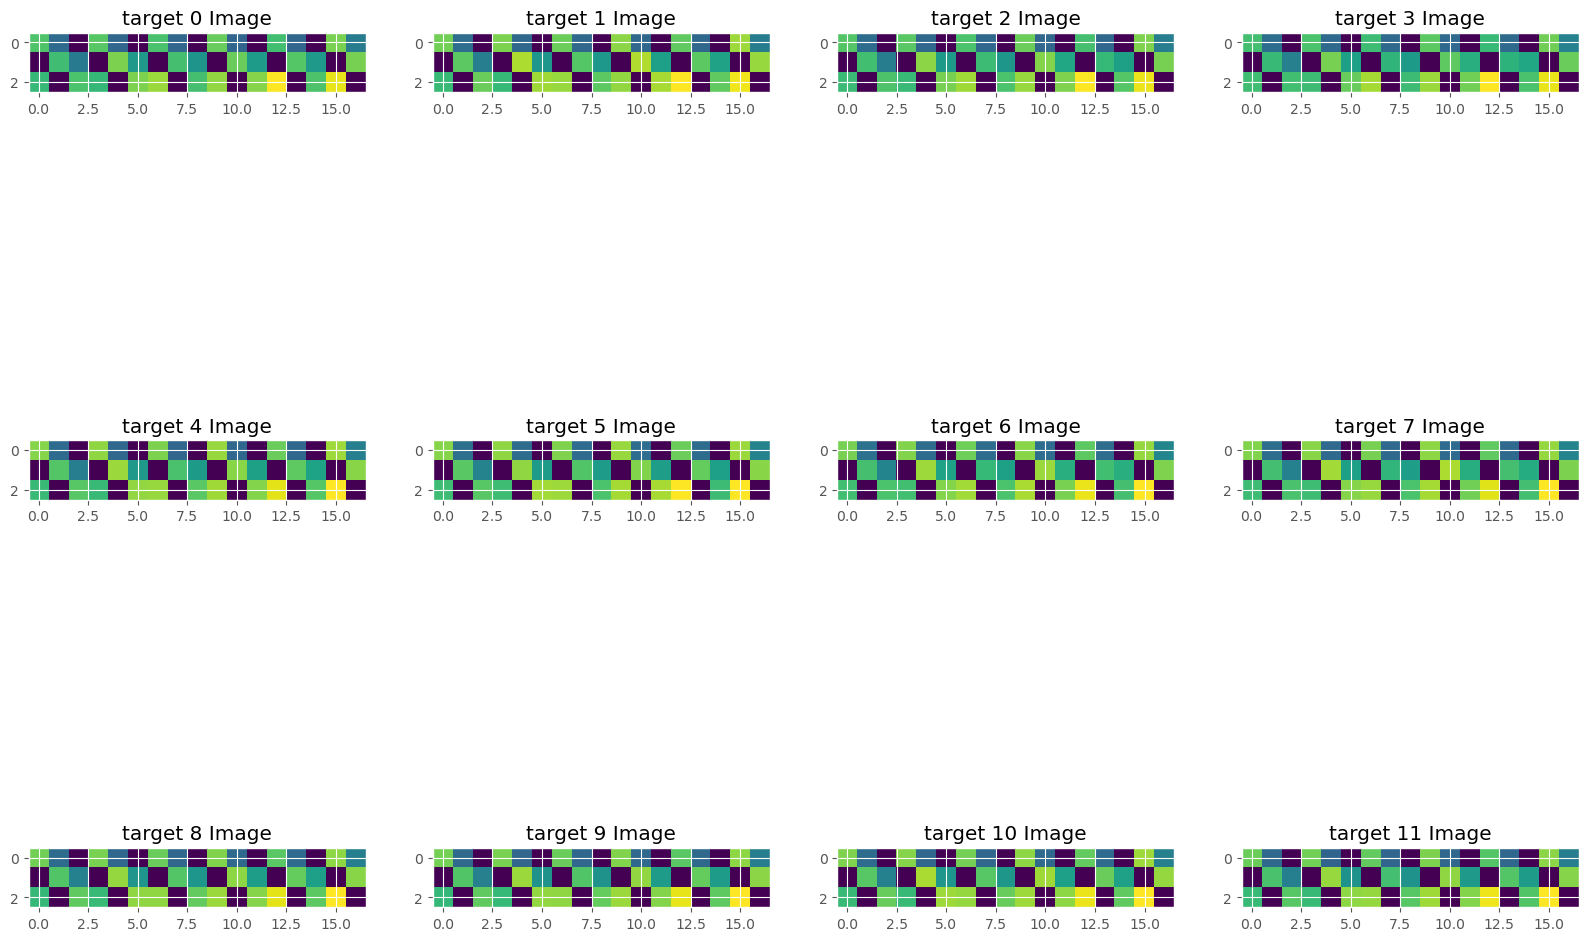

In [15]:
f, a = plt.subplots(3, 4, figsize = (20, 15))
a = a.ravel()
num_classes = 12
for i in range(num_classes) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(3, 17))

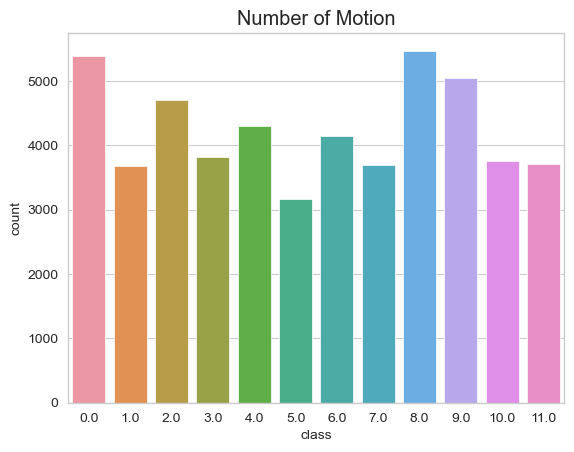

In [41]:
# 'backhand2hands': 0, 'backhand': 1, 'backhand_slice': 2, 'backhand_volley': 3 
# 'forehand_flat': 4, 'forehand_openstands': 5, 'forehand_slice': 6, 'forehand_volley': 7
# 'flat_service': 8, 'kick_service': 9, 'slice_service': 10, 'smash': 11
sns.set_style("whitegrid")
sns.countplot(x='class', data=df)
plt.title('Number of Motion')
plt.show()